## Stitch HCA_F_RepTsp13902013 & HCA_F_RepTsp13902014 (Uterovaginal canal)

In [1]:
# init 
import glob
import numpy as np
import os, sys, re
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from os import listdir
from os.path import isfile, join
from skimage.transform import rescale, resize, downscale_local_mean,  warp, AffineTransform
from PIL import Image, ImageDraw, ImageFilter
from skimage import measure, img_as_ubyte, color 
from skimage.measure import ransac
import pandas as pd
import math 
from sklearn.metrics.pairwise import euclidean_distances
import cv2
# from cellpose import utils, io, models, plot
from numpy import genfromtxt
import json

### 1. Input images 

**tissue_hires_image.png** : this is a downsampled version of the original, full-resolution image provided by the user to spaceranger. Downsampling is obtained by box filtering, which averages RGB values in patches of pixels in the full resolution images to obtain an RGB value of one pixel in the downsampled image. Downsampled images maintain the aspect ratio of the original image. 

 - For Visium slides of 6.5mm capture are, the **tissue_hires_image.png** has 2000 pixels in its largest dimension 

In [2]:
Image.MAX_IMAGE_PIXELS = 20000000000
os.chdir('/home/jovyan/RepTract/SPATIAL_ANALYSIS/ImageStitching/')
imgP1 = Image.open('OriginalImages/HCA_F_RepTsp13902013_tissue_hires_image.png')
img1 = np.array(imgP1)
print("Shape of image 1 is: {}".format(img1.shape))
imgP2 = Image.open('OriginalImages/HCA_F_RepTsp13902014_tissue_hires_image.png')
img2 = np.array(imgP2)
print("Shape of image 2 is: {}".format(img2.shape))


Shape of image 1 is: (2000, 2000, 3)
Shape of image 2 is: (2000, 2000, 3)


In [3]:
# these are a result from the TrakEM plugin in Fiji and can be found in the project .xml file that is generated 

matrix1 = [[0.5995397990218161,-0.02349530567752387],[0.02349530567752387,0.5995397990218161],[1.7799452364742372,511.3238727808189]]
matrix2 = [[0.6,0.0],[0.0,0.6],[678.2000000000002,406.4000000000001]]

M1 = np.asmatrix(np.array(matrix1)).T
M2 = np.asmatrix(np.array(matrix2)).T

### 2. Affine transformation

An affine transformation is any transformation that preserves collinearity, parallelism as well as the ratio of distances between the points (e.g. midpoint of a line remains the midpoint after transformation). It doesn’t necessarily preserve distances and angles.

Translation, rotation, scaling, etc are all affine transformations as all the above properties are preserved in these transformations. To understand in simple terms, one can think of the affine transformation as a composition of rotation, translation, scaling, and shear.

#### Usage of cv2.warpAffine() 

= function that applies an affine transformation to an image

dst = cv2.warpAffine(*src*, *M*, *dsize*)
 
 - *src*: input image
 - *M*: Transformation matrix
 - *dsize*: size of the output image

In [4]:
dst1 = cv2.warpAffine(img1,M1,(2100,2100))
dst2 = cv2.warpAffine(img2,M2,(2100,2100))

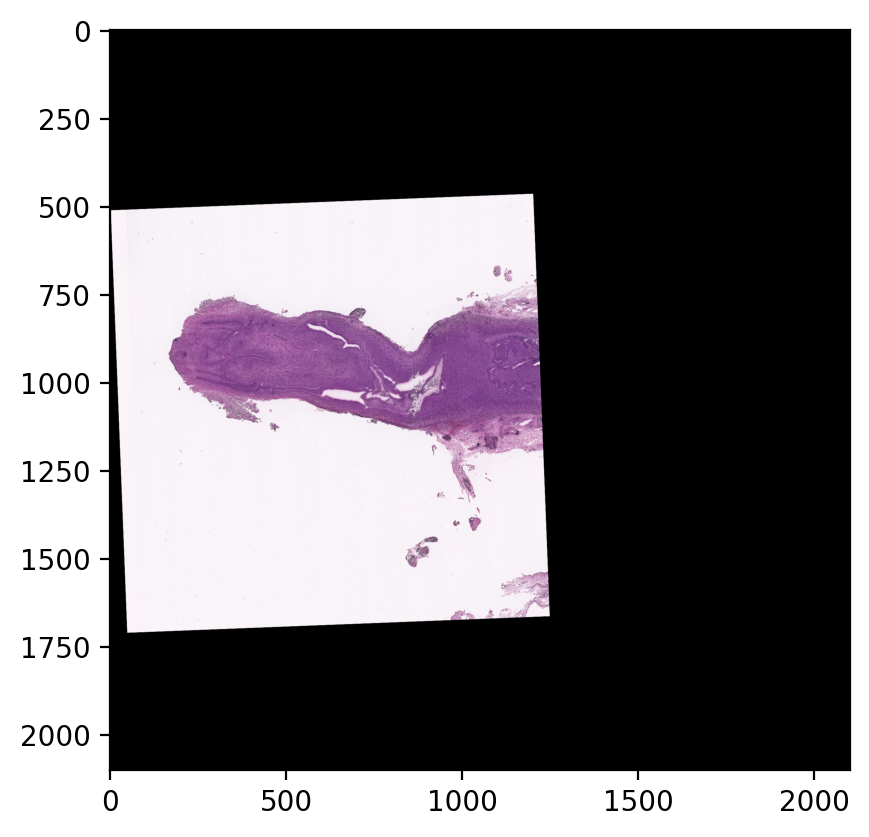

In [5]:
plt.figure(dpi=200)
plt.imshow(dst1)

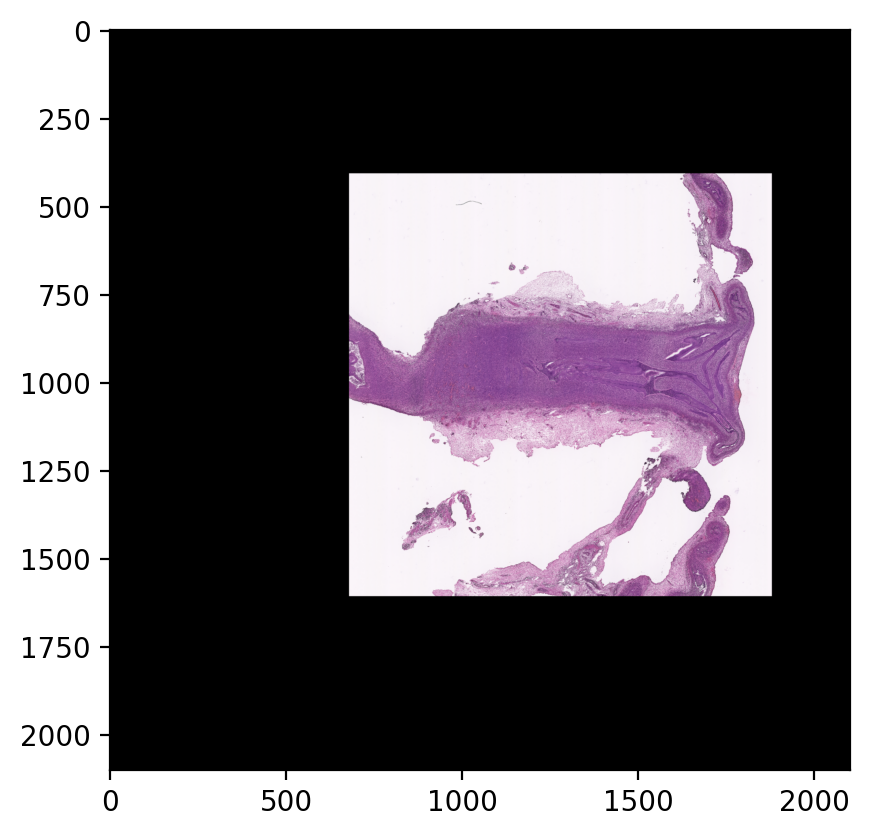

In [6]:
plt.figure(dpi=200)
plt.imshow(dst2)

### 3. Create masks around the images

In [7]:
lowbound = np.array([1, 1, 0])
upbound = np.array([255, 255, 255])

In [8]:
mask1 = cv2.inRange(dst1, lowbound, upbound)

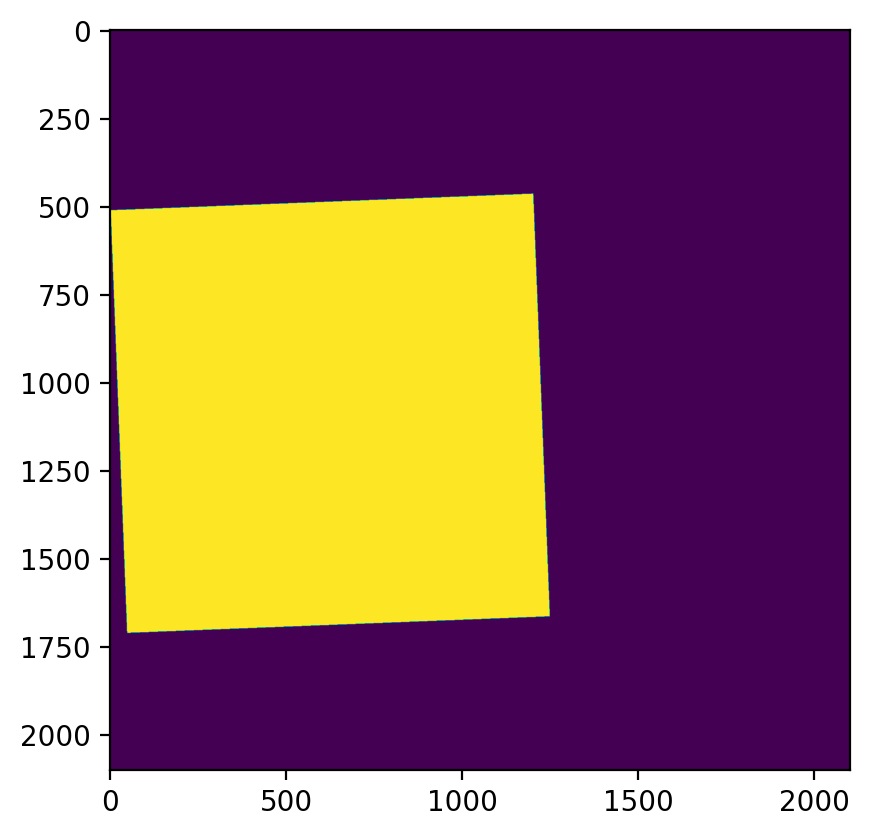

In [9]:
plt.figure(dpi=200)
plt.imshow(mask1)

In [10]:
mask2 = cv2.inRange(dst2, lowbound, upbound)

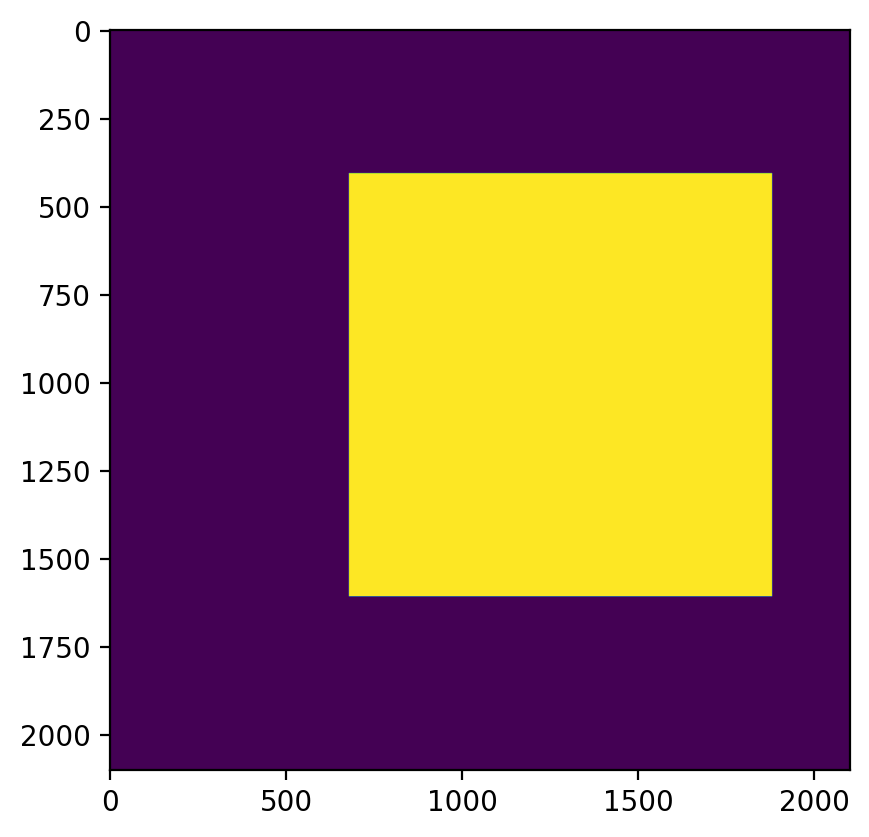

In [11]:
plt.figure(dpi=200)
plt.imshow(mask2)

### 4. Get the overlap between the two masks 

The reason we do the operation on masks is that the **bitwise_and** operation calculates the per-element bit-wise logical conjunction of two arrays and applying directly to the image gives funky results. The formula is:

dst(I) = src1(I) ∧ src2(I) if mask(I) != 0

In [12]:
overlap = cv2.bitwise_and(mask1, mask2)

In [13]:
no_overlap = cv2.bitwise_xor(mask1, mask2)

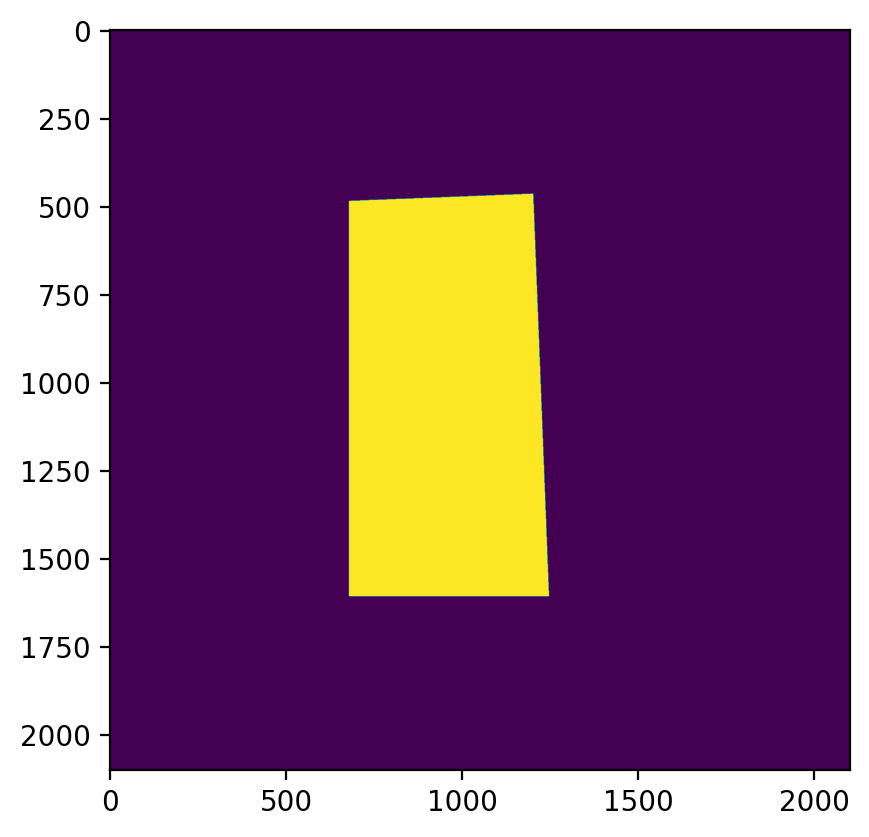

In [14]:
plt.figure(dpi=200)
plt.imshow(overlap)

### 5. Blend the images so that we get the same level of transparency for the whole image 

Haven't figured out how to do this elegantly, but because I haven't found a function in openCV that simply scales an image I am using **.addWeighted** of an image with itself to set the transparency of each image at half of its original value. 

In [15]:
partial1 = cv2.addWeighted(dst1, 0.5, dst1, 0, 0)
partial2 = cv2.addWeighted(dst2, 0.5, dst2, 0, 0)

Now that both input images are set to half their original level of transparency, add them in the overlapping region so that it gets the original transparency

In [16]:
partial_res_overlap = cv2.add(partial1, partial2, mask = overlap)

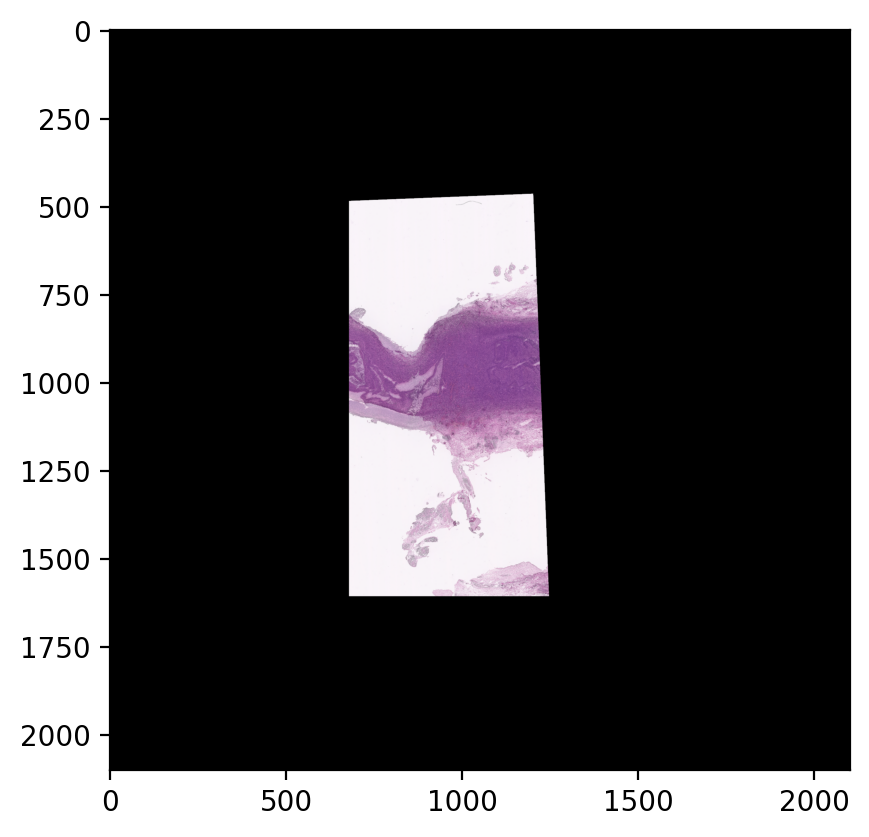

In [17]:
plt.figure(dpi=200)
plt.imshow(partial_res_overlap)

Add the original images in their non-overlapping regions

In [18]:
partial_res_no_overlap = cv2.add(dst1, dst2, mask = ~overlap)

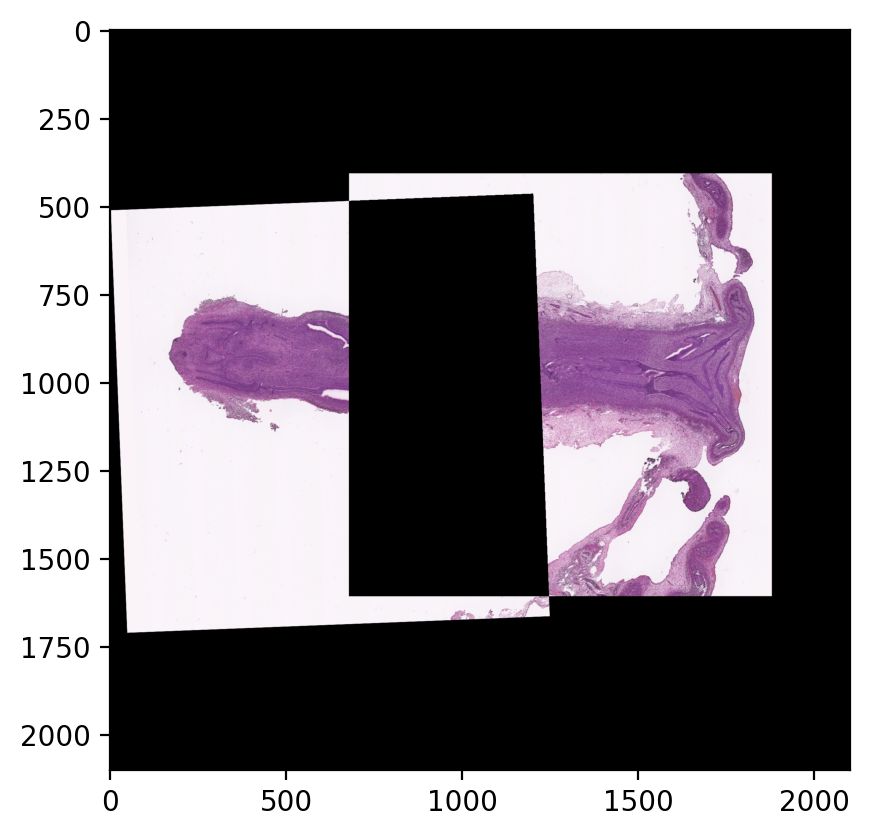

In [19]:
plt.figure(dpi=200)
plt.imshow(partial_res_no_overlap)

Add the two partial results

In [20]:
result = cv2.add(partial_res_overlap, partial_res_no_overlap)

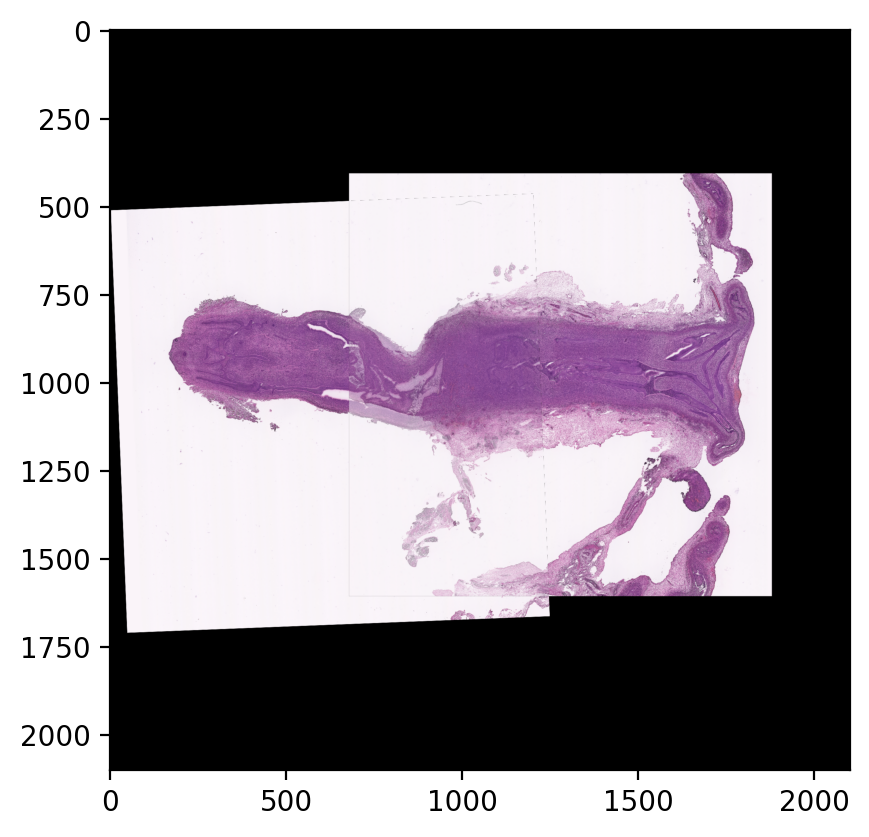

In [21]:
plt.figure(dpi=200)
plt.imshow(result)

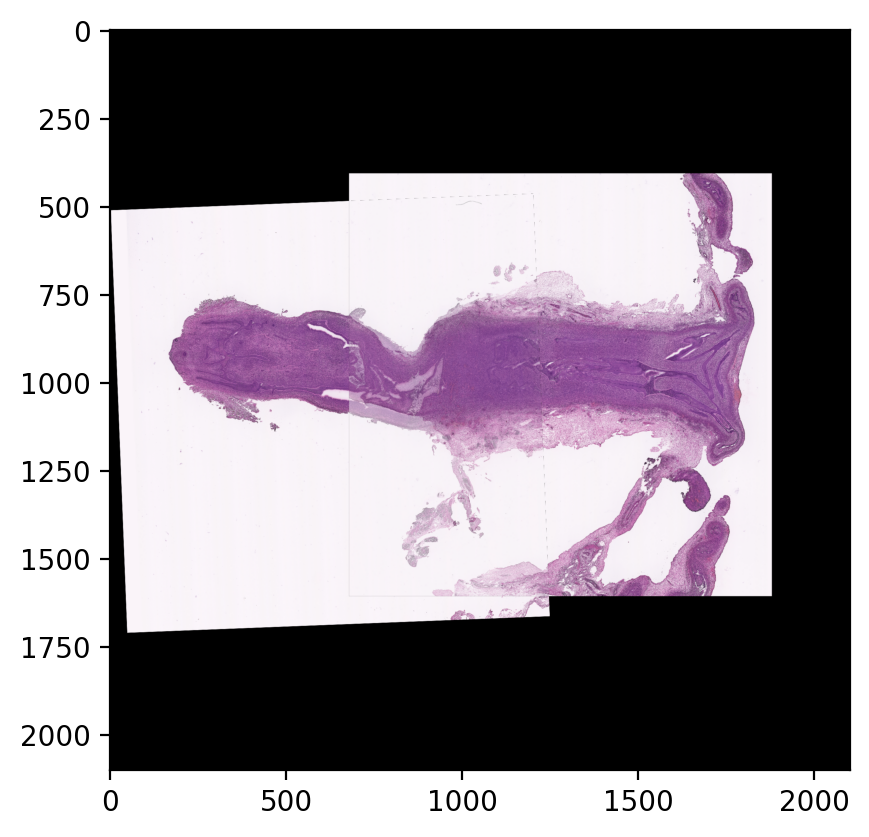

In [22]:
plt.figure(dpi=200)
plt.imshow(result)
res1 = Image.fromarray(dst1)
res1.save('HCA_F_RepTsp13902013_tissue_hires_image.png')
res2 = Image.fromarray(dst2)
res2.save('HCA_F_RepTsp13902014_tissue_hires_image.png')
res = Image.fromarray(result)
res.save('HCA_F_RepTsp13902013_14_tissue_hires_image.png')

### 6. From pixels to spots 

 - **scalefactors_json.json** file contains the following fields: 
     - *tissue_hires_scalef* = a scaling factor that converts pixel positions in the original, full-resolution image to pixel positions in the **tissue_hires_image.png**
     - *fiducial_diameter_fullres* = the number of pixels that span the diameter of a fiducial spot in the original, full resolution image 
     - *spot_diameter_fullres* = the number of pixels that span the diameter of a theoretical 65um spot in the original, full-resolution image 
     
 - **tissue_positions.csv** file contains a table with rows that correspond to spots (! this file used to be called tissue_positions_list.csv and has changed names in spaceranger v2.0. I am using spaceranger v2.0 but have renamed the file otherwise scanpy is unable to read the object). Excluding the header, the file has 4992 rows for Visium slides with 6.5 mm capture area and it is the number of spots in the spatial array. The columns correspond to the following fields: 
     - *barcode* = sequence barcode associated to the spot 
     - *in_tissue* = binary, indicating if spot falls inside (1) or outside (0) the tissue 
     - *array_row* = for Visium slide 6.5 mm capture are, the row coordinate of the spot in the array from 0 to 77 
     - *array_col* = the column coordinate of the spot in the array. In order to express the "orange crate" arrangement of the spots, for Visium slide 6.5 mm catpure area this column index uses even numbers from 0 to 126 on even row and odd numbers from 1 to 127 for odd rows with each row resulting in 64 spots. 
     - *pxl_row_in_fullres* = the row pixel coordinates of the center of the spot in the full resolution image 
     - *pxl_col_in_fullres* = the column pixel coordinates of the center of the spot in the full resolution image

In [23]:
import json
spots1 = pd.read_csv('/nfs/team292/vl6/FetalReproductiveTract/VISIUM/data/HCA_F_RepTsp13902013/spatial/tissue_positions_list.csv',header=None)
f1 = open('/nfs/team292/vl6/FetalReproductiveTract/VISIUM/data/HCA_F_RepTsp13902013/spatial/scalefactors_json.json'); data1 = json.load(f1); scale1 = data1['tissue_hires_scalef'] 
spots2 = pd.read_csv('/nfs/team292/vl6/FetalReproductiveTract/VISIUM/data/HCA_F_RepTsp13902014/spatial/tissue_positions_list.csv',header=None)
f2 = open('/nfs/team292/vl6/FetalReproductiveTract/VISIUM/data/HCA_F_RepTsp13902014/spatial/scalefactors_json.json'); data2 = json.load(f2); scale2 = data2['tissue_hires_scalef'] 

In [24]:
spots1.head()

0  1  2  3    4     5
0  GTCACTTCCTTCTAGA-1  0  0  0  894  4138
1  CACGGTCTCCTTACGA-1  0  0  2  894  4083
2  ATAGCTGCGGATAAGA-1  0  0  4  894  4028
3  GTCAGTATGTCCGGCG-1  0  0  6  894  3972
4  ATGTACCAGTTACTCG-1  0  0  8  895  3917

Both images have the same scale factors

In [25]:
print(data1['tissue_hires_scalef'])
print(data2['tissue_hires_scalef'])

0.4
0.4


In [26]:
scale2

0.4

In [27]:
# Create the Visium spot matrix by taking column and row pixel coordinates scaled by their scalefactors 
sp1 = np.asmatrix(np.vstack((np.array(spots1.iloc[:,5].values*scale1),np.array(spots1.iloc[:,4].values*scale1),np.ones(spots1.iloc[:,4].values.shape[0]))))
# Correct shape of transformation matrix 
M11 = np.append(M1, [[0,0,1]], axis = 0)
# Apply transformation matrix 
sp1TTarget = np.matmul(M11,sp1)


# Create the Visium spot matrix by taking column and row pixel coordinates scaled by their scalefactors 
sp2 = np.asmatrix(np.vstack((np.array(spots2.iloc[:,5].values*scale2),np.array(spots2.iloc[:,4].values*scale2),np.ones(spots2.iloc[:,4].values.shape[0]))))
# Correct shape of transformation matrix 
M22 = np.append(M2, [[0,0,1]], axis = 0)
# Apply transformation matrix 
sp2TTarget = np.matmul(M22,sp2)


In [28]:
sp1TTarget.shape

(3, 4991)

In [29]:
sp2TTarget.shape

(3, 4991)

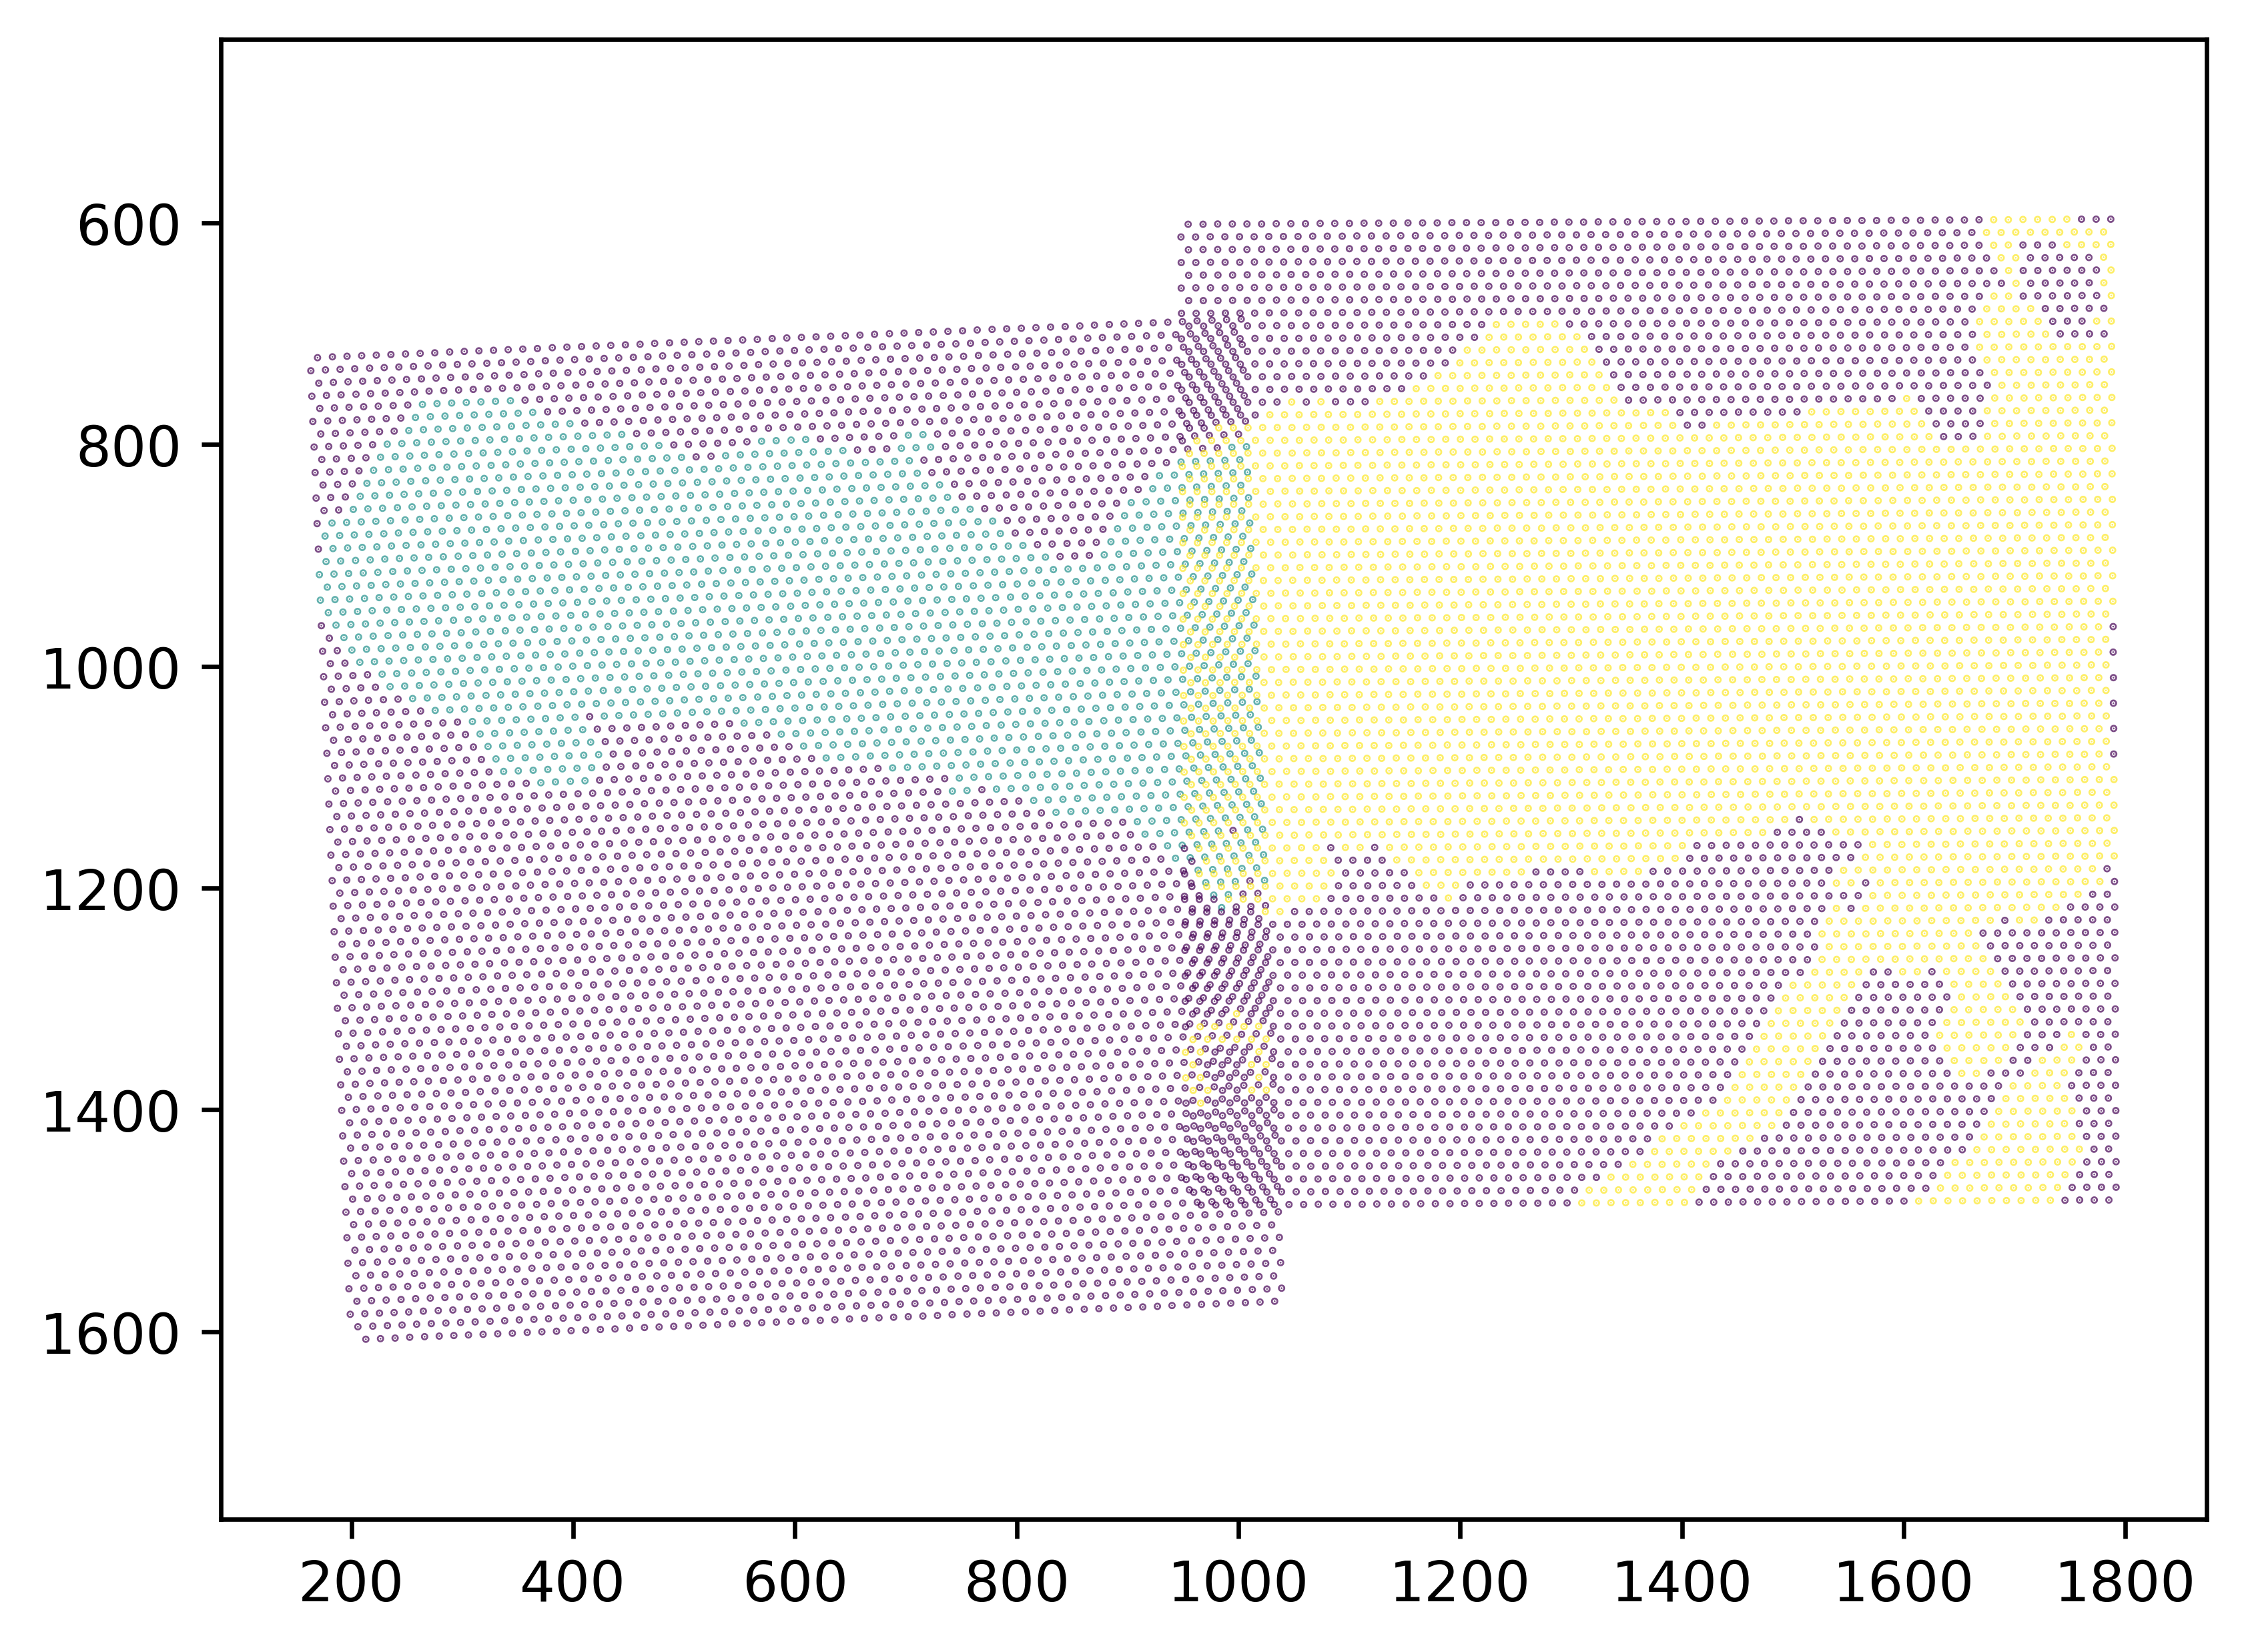

In [30]:
# Correct overlap and record the corresponding spots in both images
corresponding_spots = {}
for p in range(sp1TTarget[0].size):
    sum_array = np.sum(np.abs(sp1TTarget[:-1,:]-sp2TTarget[:-1,p]),axis=0) # Remove the last dimension of all 1s and compute distance
    min_dist = np.min(sum_array) 
    min_dist_indices = np.where(sum_array == min_dist)
    assert len(min_dist_indices) == 2 # Make sure there is only one spot in image 1 that has minimal distance to the spot we are iterating in image 2
    if min_dist<10:
        # spots2.iloc[p,1] = 0 # Set the "in_tissue" value to 0 for the overlapping spots in image 2
        corresponding_spots[min_dist_indices[1][0]] = p # Record correspondence of overlapping spots 
        
        
color = [(spots1.iloc[:,1].values).tolist(),(spots2.iloc[:,1].values*2).tolist()]
plt.figure(dpi=600)
plt.scatter([sp1TTarget[0,:].tolist(),sp2TTarget[0,:].tolist()],[sp1TTarget[1,:].tolist(),sp2TTarget[1,:].tolist()],s=0.1,c=color,alpha=0.7,facecolor=None)
plt.axis('equal')
plt.gca().invert_yaxis()

In [31]:
spots11 = spots1.copy()
spots22 = spots2.copy()

In [32]:
spots22.head()

0  1  2  3    4     5
0  GTCACTTCCTTCTAGA-1  0  0  0  793  4619
1  CACGGTCTCCTTACGA-1  0  0  2  793  4564
2  ATAGCTGCGGATAAGA-1  0  0  4  793  4509
3  GTCAGTATGTCCGGCG-1  1  0  6  793  4454
4  ATGTACCAGTTACTCG-1  1  0  8  794  4399

In [33]:
# correct coordinates
spots11.iloc[:,-2:] =  (sp1TTarget[:-1,:].T*(1/scale1)).tolist()
spots22.iloc[:,-2:] =  (sp2TTarget[:-1,:].T*(1/scale2)).tolist()

In [34]:
spots22.head()

0  1  2  3       4       5
0  GTCACTTCCTTCTAGA-1  0  0  0  4466.9  1491.8
1  CACGGTCTCCTTACGA-1  0  0  2  4433.9  1491.8
2  ATAGCTGCGGATAAGA-1  0  0  4  4400.9  1491.8
3  GTCAGTATGTCCGGCG-1  1  0  6  4367.9  1491.8
4  ATGTACCAGTTACTCG-1  1  0  8  4334.9  1492.4

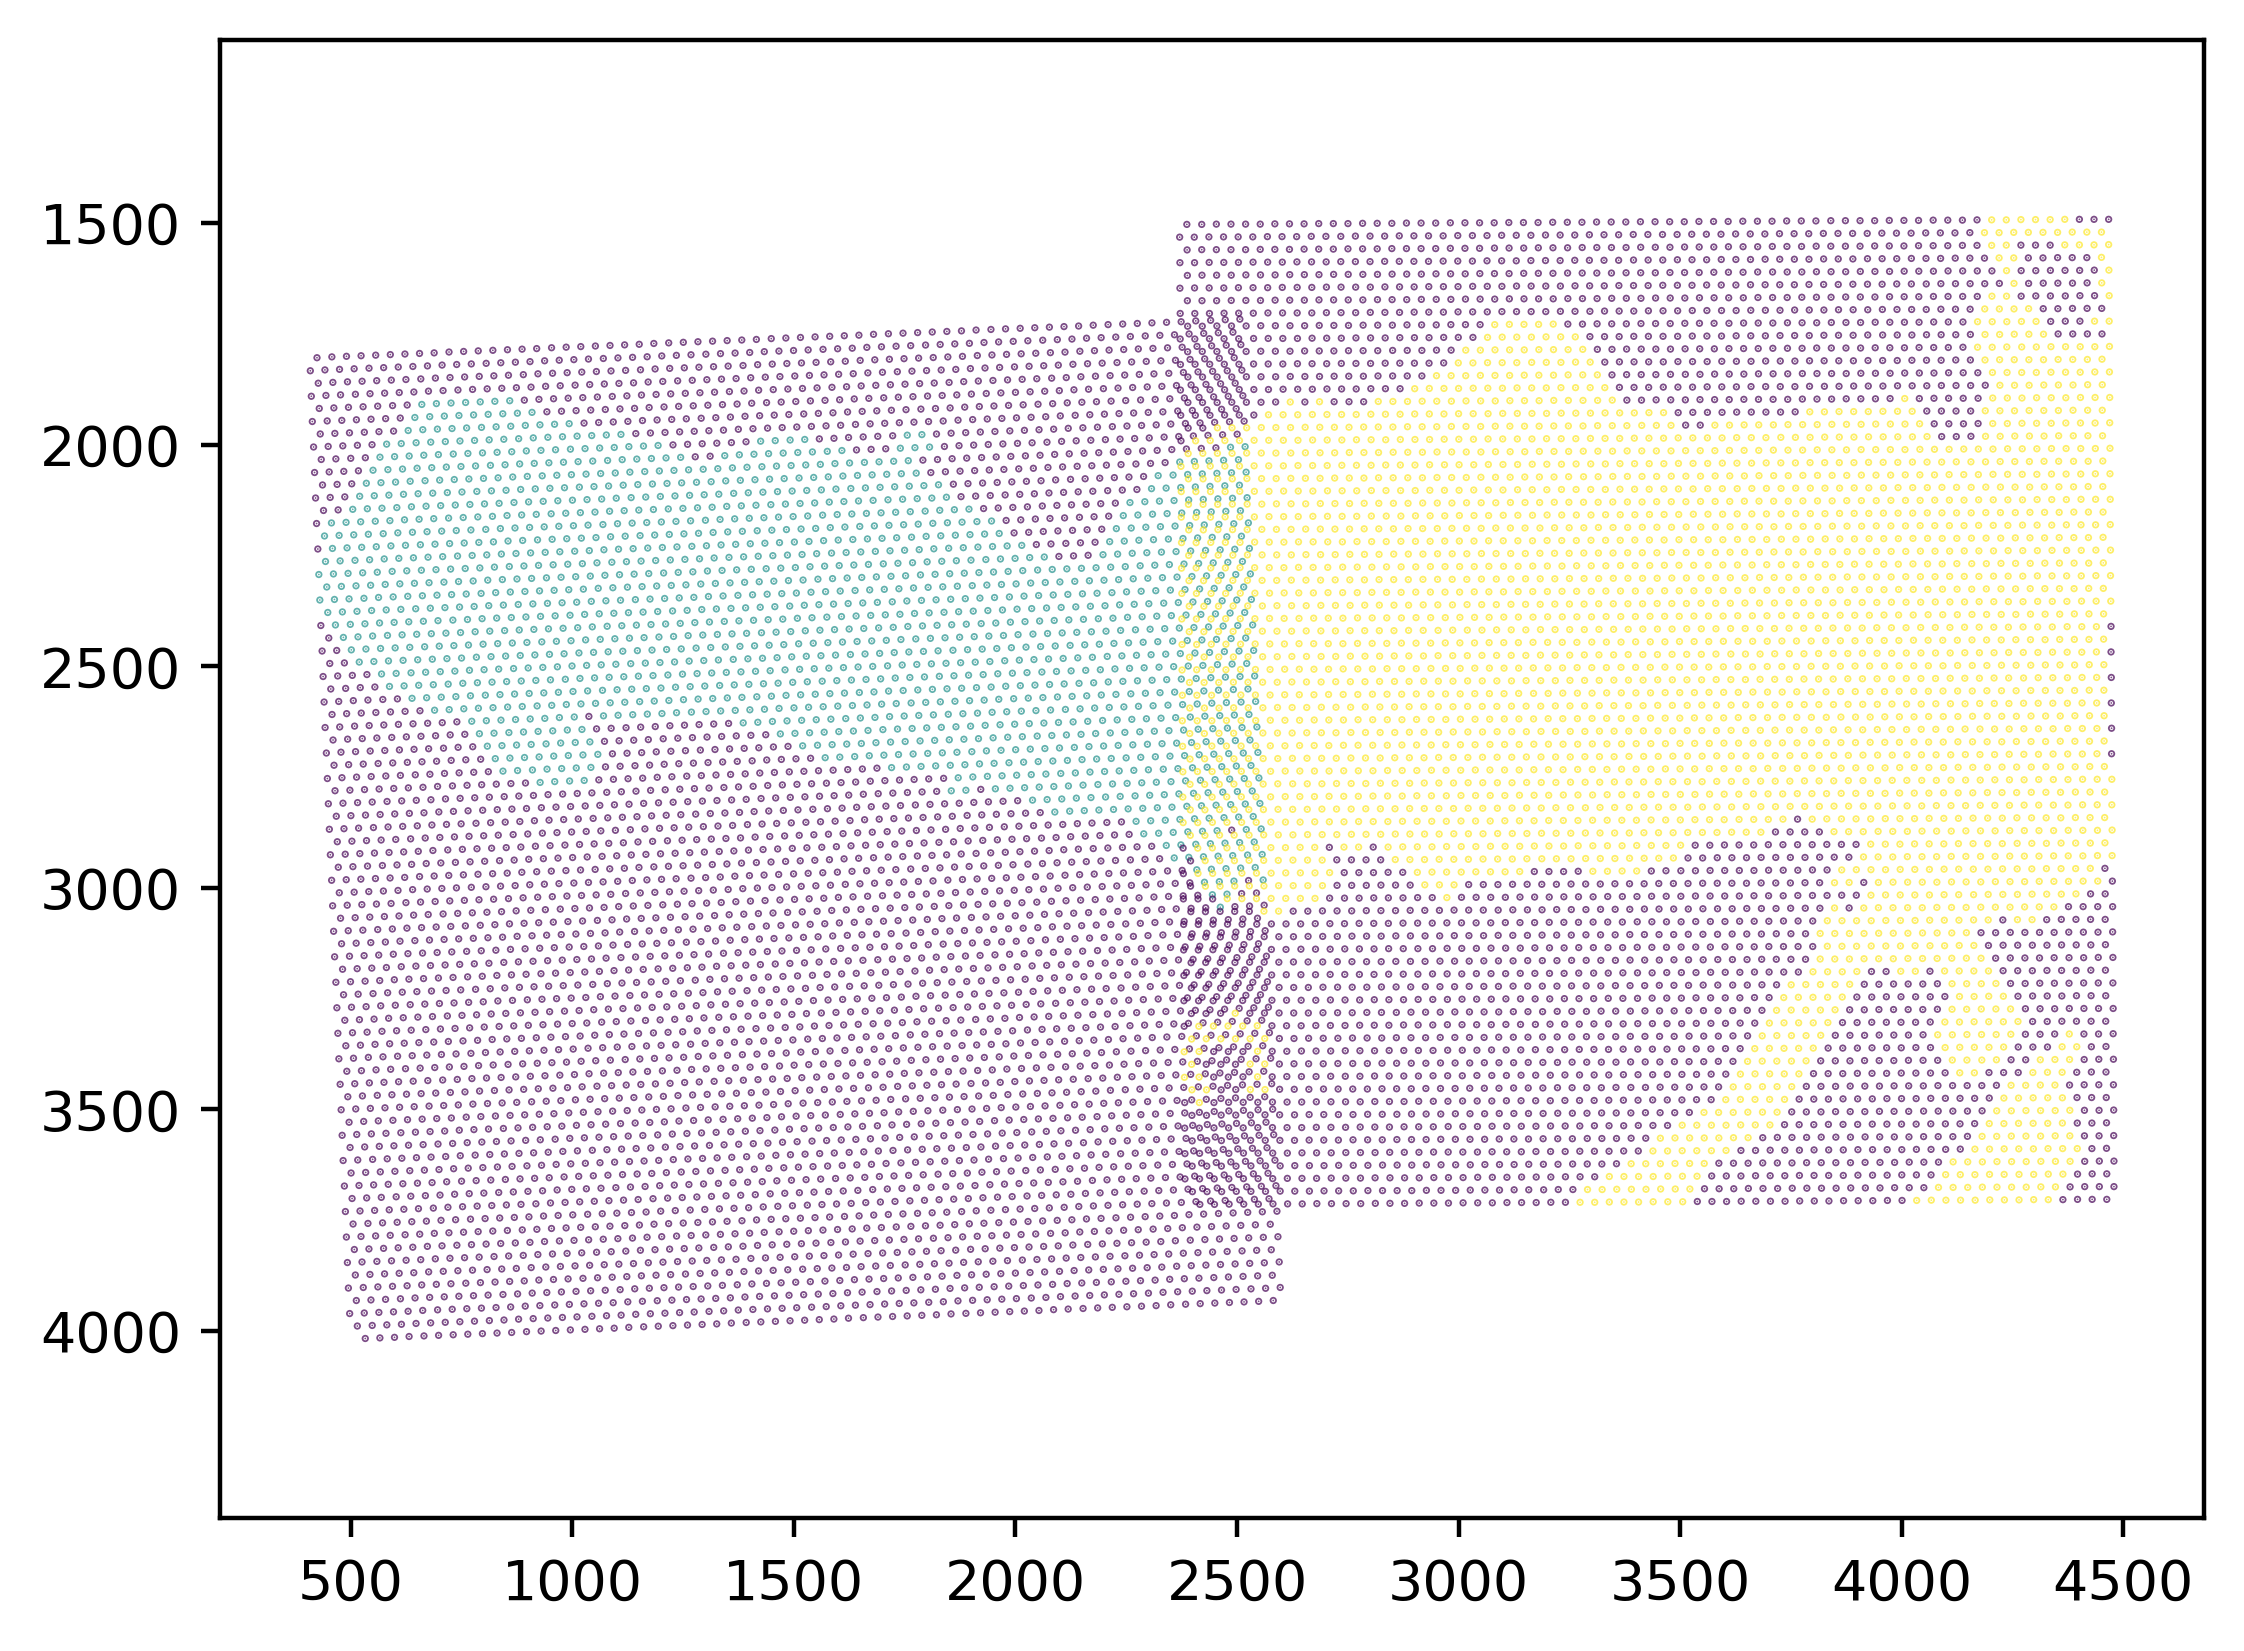

In [35]:
#make sure everything is ok 
color = [(spots11.iloc[:,1].values).tolist(),(spots22.iloc[:,1].values*2).tolist()]
plt.figure(dpi=400)
plt.scatter([spots11.iloc[:,4].values.tolist(),spots22.iloc[:,4].values.tolist()],[spots11.iloc[:,5].values.tolist(),spots22.iloc[:,5].values.tolist()],s=0.1,c=color,alpha=0.7,facecolor=None)
plt.axis('equal')
plt.gca().invert_yaxis()

In [36]:
spots11[0] = ["HCA_F_RepTsp13902013_"+i for i in spots11[0]]

In [37]:
spots22[0] = ["HCA_F_RepTsp13902014_"+i for i in spots22[0]]

### Save the overlapping barcodes as .json file

In [38]:
overlapping_barcodes = {}
for k, v in corresponding_spots.items():
    overlapping_barcodes[spots11.iloc[k,0]] = spots22.iloc[v,0]

In [39]:
len(list(overlapping_barcodes.keys()))

394

In [40]:
len(np.unique(list(overlapping_barcodes.keys())))

394

In [41]:
import json
with open("HCA_F_RepTsp13902013_14_overlapping_barcodes.json", "w") as f:
    json.dump(overlapping_barcodes, f)

In [42]:
spots11.to_csv('HCA_F_RepTsp13902013_tissue_positions_list.csv',header=False,index=False)
spots22.to_csv('HCA_F_RepTsp13902014_tissue_positions_list.csv',header=False,index=False)